In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import Word
import nltk
import wordcloud


import warnings 
warnings.filterwarnings("ignore")

In [2]:
data_training = pd.read_csv(r"C:\Users\ASUS\Desktop\datasets\Malignant Comments Classifier Project\train.csv")
data_testing = pd.read_csv(r"C:\Users\ASUS\Desktop\datasets\Malignant Comments Classifier Project\test.csv")

In [3]:
data_training.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
data_testing.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
data_training.shape

(159571, 8)

In [6]:
data_training.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [7]:
data_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [8]:
data_training.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
data_training.nunique()

id                  159571
comment_text        159571
malignant                2
highly_malignant         2
rude                     2
threat                   2
abuse                    2
loathe                   2
dtype: int64

In [10]:
# Creating new columns just for the sake of EDA
data_training["Original_length"] = data_training["comment_text"].str.len()

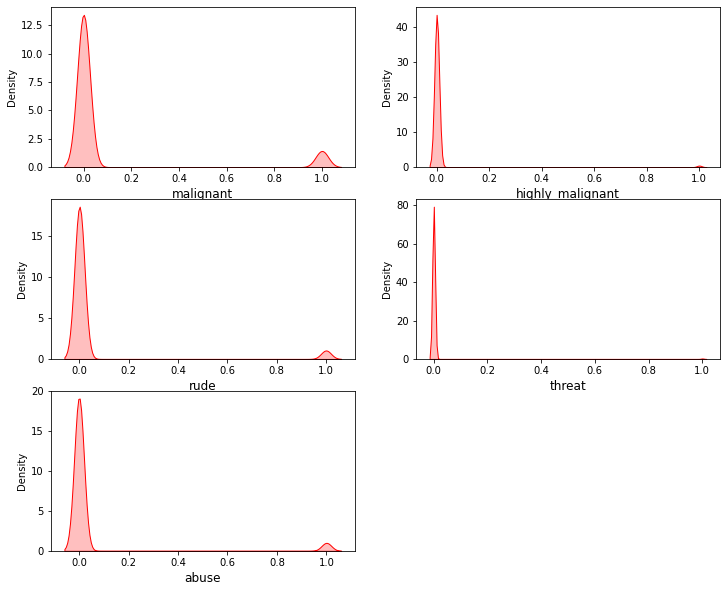

In [11]:
num = data_training.select_dtypes(exclude='O')
plt.figure(figsize=(12,10))
plotnumber =1
for i in num.drop("Original_length",axis=1):
  if plotnumber<6:
    ax = plt.subplot(3,2,plotnumber)
    sns.kdeplot(num[i],fill=True,color='r')
    plt.xlabel(i,fontsize=12)
  plotnumber+=1
plt.show()

From above plot we can see that there is only two categories all fives i.e malignant, highly_malignant, rude, threat and abuse have only two class whether it's a 0 or 1.

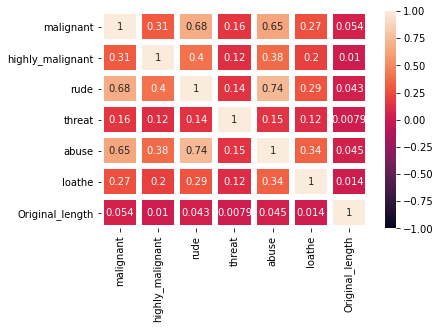

In [12]:
df_corr = data_training.corr().abs()
sns.heatmap(df_corr,vmin=-1,vmax=1,linewidth=5,annot=True,fmt='.2g')
plt.show()

From above we can see that all the features have correlation with eachother at some extent

### Data Cleaning

In [18]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def cleaning(df,stop_words):
    #Converting to lower case
    df["comment_text"] = df["comment_text"].str.lower()
    
    # Removing stopwords
    df["comment_text"] = df["comment_text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
    
    # Removing Extra Whitespaces
    df["comment_text"] = df["comment_text"].str.replace(r'^\s+'," ")
    
    # Lemmatization
    df["comment_text"] = df["comment_text"].apply(lambda x:" ".join([lemmatizer.lemmatize(x) for x in x.split()]))
    
    # Removing Punchuation
    df["comment_text"] = df["comment_text"].str.replace(r'[^\w\d\s]',"")
    
    # Removing Numbers
    
    df["comment_text"] = df["comment_text"].str.replace('d'," ")
    
    # Removing Extra Whitespaces
    df["comment_text"] = df["comment_text"].str.replace(r'^\s+'," ")
    
    # Replacing Email address
    df["comment_text"]= df["comment_text"].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',"emailaddress")
    
    # Replacing \n
    df["comment_text"] = df["comment_text"].replace("\n"," ")
    
    return df

# I am appending few stopwords which people uses while writting any comment
stop_words = set(stopwords.words("english")+["aww","hmm","cant","dont","u","ur","4","d","e","im","hey","yo","ja"])
data_training = cleaning(data_training,stop_words)

In [19]:
# Creating Target column using pipe. If one or more columns contain 1 then the label columns also contain 1 otherwise 0
data_training["Label"] = data_training["malignant"]|data_training["highly_malignant"]|data_training["rude"]|data_training["threat"]|data_training["abuse"]|data_training["loathe"]

In [20]:
data_training['lenght_after_cleaning'] = data_training["comment_text"].str.len()

In [21]:
data_training.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,Original_length,Label,lenght_after_cleaning
0,0000997932d777bf,explanation username har core metallica fan re...,0,0,0,0,0,0,264,0,156
1,000103f0d9cfb60f,match backgroun colour seemingly stuck thanks ...,0,0,0,0,0,0,112,0,75
2,000113f07ec002fd,man really trying war guy constantly removing ...,0,0,0,0,0,0,233,0,125
3,0001b41b1c6bb37e,make real suggestion improvement ere section s...,0,0,0,0,0,0,622,0,357
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0,67,0,35


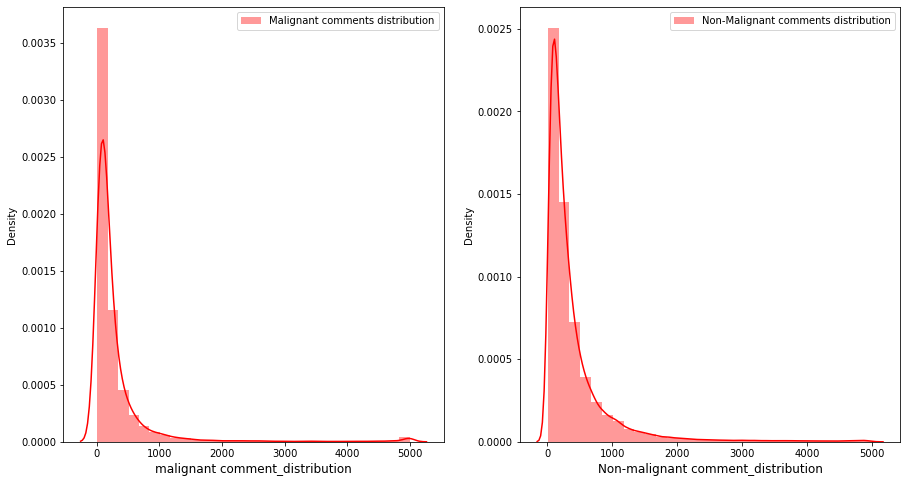

In [22]:
# comment_text distribution before cleaning

f,ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(data_training[data_training['Label']==1]["Original_length"],bins=30,color='r',ax=ax[0],label='Malignant comments distribution')
ax[0].set_xlabel("malignant comment_distribution",fontsize=12)
ax[0].legend()

sns.distplot(data_training[data_training['Label']==0]["Original_length"],bins=30,color='r',ax=ax[1],label='Non-Malignant comments distribution')
ax[1].set_xlabel("Non-malignant comment_distribution",fontsize=12)
ax[1].legend()

plt.show()

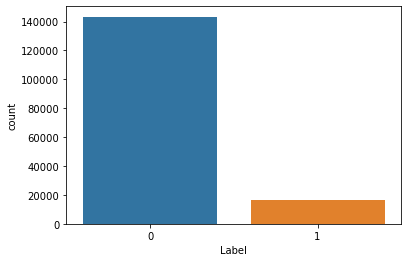

In [23]:
# Target Column data distribution
sns.countplot(data_training["Label"],data=data_testing)
plt.show()

In [24]:
data_training["Label"].value_counts()

0    143346
1     16225
Name: Label, dtype: int64

In [25]:
print("Percentage of non-malignant comments :",(data_training["Label"].value_counts()[0]/(data_training.shape[0]))*100,"%")
print("Percentage of Malignant comments :",(data_training["Label"].value_counts()[1]/(data_training.shape[0]))*100,"%")

Percentage of non-malignant comments : 89.83211235124176 %
Percentage of Malignant comments : 10.167887648758233 %


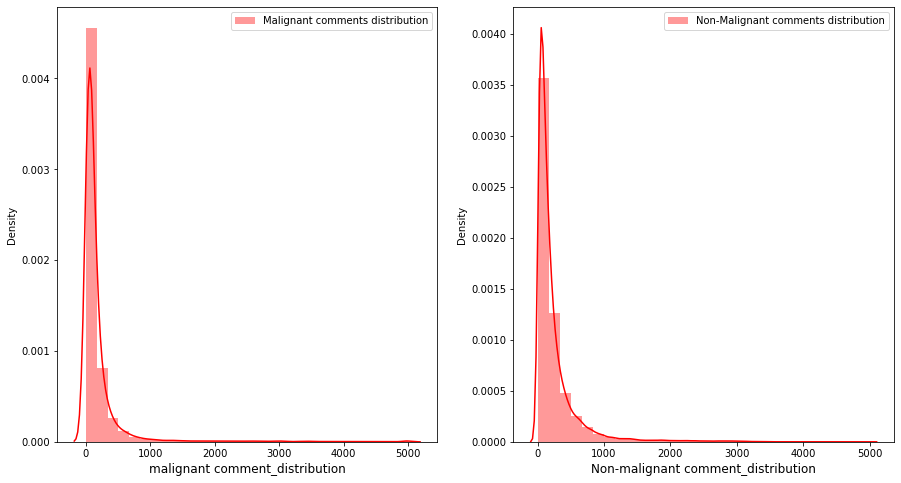

In [26]:
# comment_text distribution before cleaning

f,ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(data_training[data_training['Label']==1]["lenght_after_cleaning"],bins=30,color='r',ax=ax[0],label='Malignant comments distribution')
ax[0].set_xlabel("malignant comment_distribution",fontsize=12)
ax[0].legend()

sns.distplot(data_training[data_training['Label']==0]["lenght_after_cleaning"],bins=30,color='r',ax=ax[1],label='Non-Malignant comments distribution')
ax[1].set_xlabel("Non-malignant comment_distribution",fontsize=12)
ax[1].legend()

plt.show()

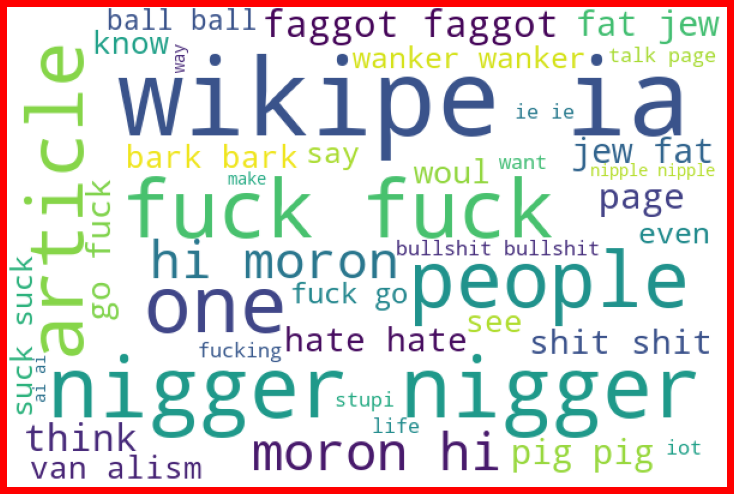

In [27]:
# Frequent Word used in malignant comments
from wordcloud import WordCloud
malignant = data_training["comment_text"][data_training["Label"]==1]
wordcloud = WordCloud(width=600,height=400,background_color='white',max_words=40).generate(" ".join(malignant))
plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

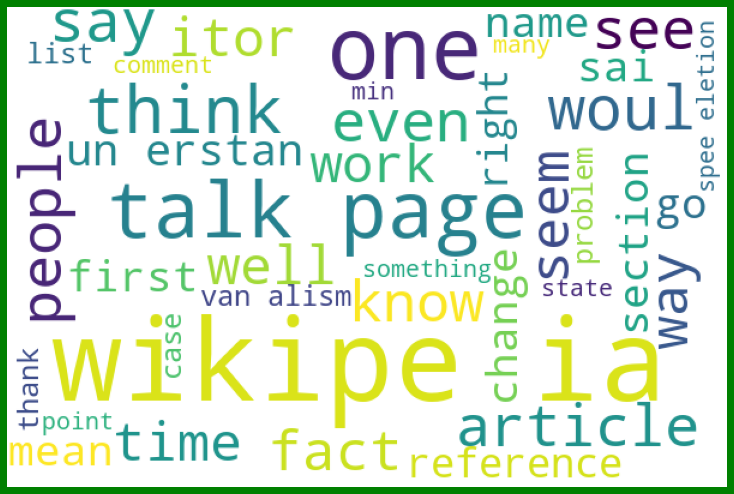

In [28]:
# Frequent Words in non malignant comments
from wordcloud import WordCloud
malignant = data_training["comment_text"][data_training["Label"]==0]
wordcloud = WordCloud(width=600,height=400,background_color='white',max_words=40).generate(" ".join(malignant))
plt.figure(figsize=(10,8),facecolor='g')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [29]:
# Converting text into vectors
tf_vec = TfidfVectorizer()
features = tf_vec.fit_transform(data_training["comment_text"])

## cleaning the testing Dataset

In [30]:
data_testing.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [31]:
data_testing.shape

(153164, 2)

In [32]:
data_testing.isnull().sum()

id              0
comment_text    0
dtype: int64

In [33]:
# Passing the testing dataset in cleaning function
data_testing = cleaning(data_testing,stop_words)

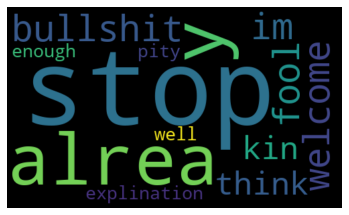

In [34]:
common_word = ""
for i in data_testing.comment_text:
    i = str(i)
    tokens= i.split()
    common_word = " ".join(tokens)+" "
wordcloud = WordCloud(width=500,height=300).generate(common_word)
plt.figure(figsize=(6,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
data_testing.drop("id",axis=1,inplace=True)

<AxesSubplot:xlabel='Label', ylabel='count'>

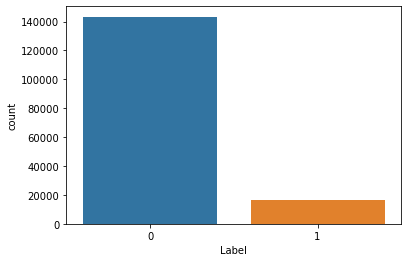

In [36]:
# Checking the data distribution of the target column
sns.countplot(data_training["Label"])

**As we can see that there is huge class imbalanced in the target columns so i am gonna consider F1 score for best model**

### Splitting Dataset

In [37]:
'''i have convert only comment_text columns in to vectors therefore there is no need todrop any other columns.
I have alread assign the required columns in x and y'''
x = features
y = data_training["Label"]

## Model Buiding

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score,classification_report,f1_score,confusion_matrix,log_loss
from sklearn.model_selection import train_test_split,cross_val_score

In [39]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=123)

In [40]:
a =[]
c=[]
f=[]
log=[]

### MultinomialNB

In [41]:
mnb = MultinomialNB()
mnb.fit(x_train,y_train)

MultinomialNB()

In [42]:
y_pred = mnb.predict(x_test)

In [43]:
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),
      "\n","=-"*60,"\n","Cross Validation Score :",cross_val_score(mnb,x,y,cv=5).mean(),"\n","=-"*60,"\nLog loss :",log_loss(y_test,y_pred,normalize=True),
      "\n","=-"*60,"\nF1 Score :",f1_score(y_pred,y_test))

Accuracy Score is: 0.9165691844919787 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     43112
           1       0.98      0.16      0.28      4760

    accuracy                           0.92     47872
   macro avg       0.95      0.58      0.62     47872
weighted avg       0.92      0.92      0.89     47872
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.9151725571497369 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
Log loss : 2.8815984817104456 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
F1 Score : 0.2803603603603604


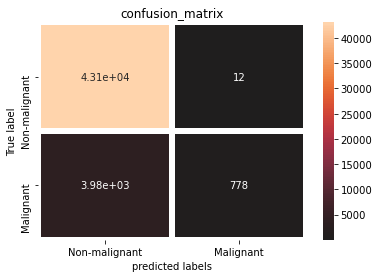

In [44]:
conf = confusion_matrix(y_test,y_pred)
axes=plt.subplot()
sns.heatmap(conf,annot=True,linewidths=5,center=0,ax=axes,fmt=".3g")
axes.set_xlabel('predicted labels')
axes.set_ylabel("True label")
axes.set_title('confusion_matrix')
axes.xaxis.set_ticklabels(["Non-malignant","Malignant"])
axes.yaxis.set_ticklabels(["Non-malignant","Malignant"])
plt.show()

In [45]:
a.append(accuracy_score(y_test,y_pred))
c.append(cross_val_score(mnb,x,y,cv=5).mean())
f.append(f1_score(y_pred,y_test))
log.append(log_loss(y_test,y_pred))

### Logistic Regression

In [46]:
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)

LogisticRegression()

In [47]:
y_pred = log_reg.predict(x_test)

In [48]:
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),
      "\n","=-"*60,"\n","Cross Validation Score :",cross_val_score(log_reg,x,y,cv=5).mean(),"\n","=-"*60,"\nLog loss :",log_loss(y_test,y_pred)
      ,"\n","=-"*60,"\nF1 Score :",f1_score(y_pred,y_test))

Accuracy Score is: 0.9544410093582888 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     43112
           1       0.94      0.58      0.72      4760

    accuracy                           0.95     47872
   macro avg       0.95      0.79      0.85     47872
weighted avg       0.95      0.95      0.95     47872
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.9531431129275234 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
Log loss : 1.5735549974934582 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
F1 Score : 0.7175967888126377


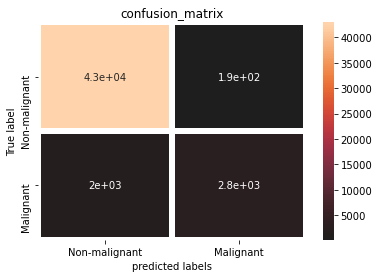

In [49]:
conf = confusion_matrix(y_test,y_pred)
axes=plt.subplot()
sns.heatmap(conf,annot=True,linewidths=5,center=0,ax=axes)
axes.set_xlabel('predicted labels')
axes.set_ylabel("True label")
axes.set_title('confusion_matrix')
axes.xaxis.set_ticklabels(["Non-malignant","Malignant"])
axes.yaxis.set_ticklabels(["Non-malignant","Malignant"])
plt.show()

In [50]:
a.append(accuracy_score(y_test,y_pred))
c.append(cross_val_score(log_reg,x,y,cv=5).mean())
f.append(f1_score(y_pred,y_test))
log.append(log_loss(y_test,y_pred))

### DecisionTreeClassifier

In [51]:
dt =  DecisionTreeClassifier()
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [52]:
y_pred = dt.predict(x_test)

In [53]:
cv=cross_val_score(dt,x,y,cv=5).mean()
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),
      "\n","=-"*60,"\n","Cross Validation Score :",cv,"\n","=-"*60,"\nLog loss :",log_loss(y_test,y_pred),"\n","=-"*60,
      "\nF1 Score :",f1_score(y_pred,y_test))

Accuracy Score is: 0.9447067179144385 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     43112
           1       0.73      0.70      0.72      4760

    accuracy                           0.94     47872
   macro avg       0.85      0.84      0.84     47872
weighted avg       0.94      0.94      0.94     47872
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.9423642129795186 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
Log loss : 1.909782917374613 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
F1 Score : 0.7166256289476501


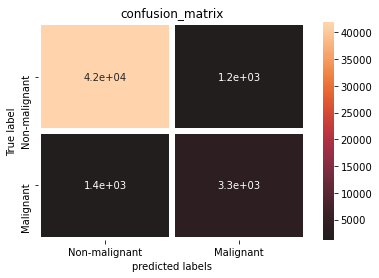

In [54]:
conf = confusion_matrix(y_test,y_pred)
axes=plt.subplot()
sns.heatmap(conf,annot=True,linewidths=5,center=0,ax=axes)
axes.set_xlabel('predicted labels')
axes.set_ylabel("True label")
axes.set_title('confusion_matrix')
axes.xaxis.set_ticklabels(["Non-malignant","Malignant"])
axes.yaxis.set_ticklabels(["Non-malignant","Malignant"])
plt.show()

In [55]:
a.append(accuracy_score(y_test,y_pred))
c.append(cv)
f.append(f1_score(y_pred,y_test))
log.append(log_loss(y_test,y_pred))

### XGB Classifier

In [56]:
xgb = XGBClassifier(verbosity=0)
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [57]:
y_pred = xgb.predict(x_test)

In [58]:
cv = cross_val_score(xgb,x,y,cv=5).mean()
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),
      "\n","=-"*60,"\n","Cross Validation Score :",cv,"\n","=-"*60,"\n Log loss :",log_loss(y_test,y_pred),"\n","=-"*60,
      "\n F1 Score :",f1_score(y_pred,y_test))

Accuracy Score is: 0.9549423462566845 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     43112
           1       0.91      0.61      0.73      4760

    accuracy                           0.95     47872
   macro avg       0.94      0.80      0.85     47872
weighted avg       0.95      0.95      0.95     47872
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.9527859076382927 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Log loss : 1.5562408542010058 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 F1 Score : 0.7275483137552102


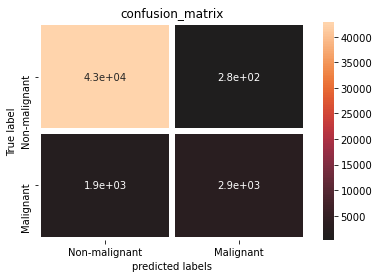

In [59]:
conf = confusion_matrix(y_test,y_pred)
axes=plt.subplot()
sns.heatmap(conf,annot=True,linewidths=5,center=0,ax=axes)
axes.set_xlabel('predicted labels')
axes.set_ylabel("True label")
axes.set_title('confusion_matrix')
axes.xaxis.set_ticklabels(["Non-malignant","Malignant"])
axes.yaxis.set_ticklabels(["Non-malignant","Malignant"])
plt.show()

In [60]:
a.append(accuracy_score(y_test,y_pred))
c.append(cv)
f.append(f1_score(y_pred,y_test))
log.append(log_loss(y_test,y_pred))

In [61]:
model = ["MultnomialNB","Logistic Regression","DecisionTreeClassifier","XGBClassifier"]

best_model=pd.DataFrame({"Model":model,"Accuracy score":a,"Cross Validation Score":c,"Log loss":log,"F1 score":f})
best_model

,Model,Accuracy score,Cross Validation Score,Log loss,F1 score
0,MultnomialNB,0.916569,0.915173,2.881598,0.280360
1,Logistic Regression,0.954441,0.953143,1.573555,0.717597
2,DecisionTreeClassifier,0.944707,0.942364,1.909783,0.716626
3,XGBClassifier,0.954942,0.952786,1.556241,0.727548


As we know when that when the dataset is imbalanced at that time we need to consider **F1 Score** to choose the Best Model. Here that model is **XGB Classifier** So i am gonna tune that model with best parameter using hyperparameter Tunning.

### Hyperparameter Tunning

In [84]:
params = {"gamma":[0.9,1],
          "random_state":[250,123],
         "n_estimators":[100,200]}

In [85]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
rand_search = RandomizedSearchCV(xgb,param_distributions=params,cv=2,n_jobs=-1)

In [86]:
rand_search.fit(x_train,y_train)

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False, gamma=1,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_extimators=100,
                                           n_jobs=8, num_parallel_tree=1,
                                        

In [87]:
rand_search.best_params_

{'random_state': 250, 'n_estimators': 200, 'gamma': 1}

In [97]:
xgb = XGBClassifier(n_extimators=200,gamma=1,random_state=250)
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_extimators=200,
              n_jobs=8, num_parallel_tree=1, predictor='auto', random_state=250,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [98]:
y_pred = xgb.predict(x_test)

In [99]:
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),
      "\n","=-"*60,"\n","Cross Validation Score :",cross_val_score(xgb,x,y,cv=5).mean(),"\n","=-"*60,"\n Log loss :",log_loss(y_test,y_pred),"\n","=-"*60,
      "\n F1 Score :",f1_score(y_pred,y_test))

Accuracy Score is: 0.9546916778074866 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     43112
           1       0.91      0.60      0.73      4760

    accuracy                           0.95     47872
   macro avg       0.93      0.80      0.85     47872
weighted avg       0.95      0.95      0.95     47872
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.95308044902243 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Log loss : 1.5648986524199302 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 F1 Score : 0.7256861009232326


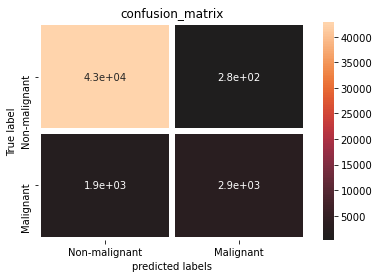

In [100]:
conf = confusion_matrix(y_test,y_pred)
axes=plt.subplot()
sns.heatmap(conf,annot=True,linewidths=5,center=0,ax=axes)
axes.set_xlabel('predicted labels')
axes.set_ylabel("True label")
axes.set_title('confusion_matrix')
axes.xaxis.set_ticklabels(["Non-malignant","Malignant"])
axes.yaxis.set_ticklabels(["Non-malignant","Malignant"])
plt.show()

In [101]:
from sklearn.metrics import roc_curve,roc_auc_score,plot_roc_curve

In [102]:
#LogisticRegression
print("Logistic Regression roc_auc_score",roc_auc_score(y_test,log_reg.predict(x_test)))

#MultinomialNB
print("MultinomialNB roc_auc_score",roc_auc_score(y_test,mnb.predict(x_test)))

#DecisionTreeClassifier
print("DecisionTreeClassifier roc_auc_score",roc_auc_score(y_test,dt.predict(x_test)))

#XGBClassifer
print("XGBClassifier roc_auc_score",roc_auc_score(y_test,xgb.predict(x_test)))


Logistic Regression roc_auc_score 0.7888446703602577
MultinomialNB roc_auc_score 0.5815835166874321
DecisionTreeClassifier roc_auc_score 0.8372640696657213
XGBClassifier roc_auc_score 0.7981413858918961


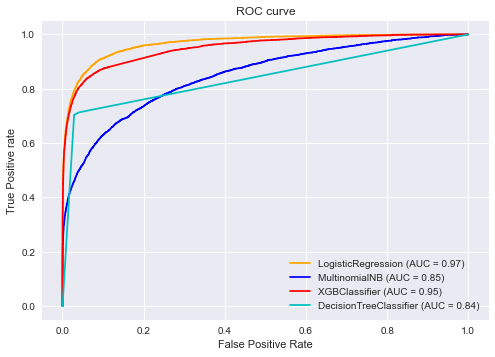

In [103]:
plt.style.use('seaborn')

disp = plot_roc_curve(log_reg,x_test,y_test,color='orange')
plot_roc_curve(mnb,x_test,y_test,color='b',ax=disp.ax_)
plot_roc_curve(xgb,x_test,y_test,color='red',ax=disp.ax_)
plot_roc_curve(dt,x_test,y_test,color='c',ax=disp.ax_)


plt.title('ROC curve')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [104]:
import pickle
pickle.dump(xgb,open("Malignant_n_non_malignant.pk1","wb"))

In [105]:
load_model = pickle.load(open("Malignant_n_non_malignant.pk1","rb"))

### Passing Testing Data

In [106]:
test = tf_vec.transform(data_testing["comment_text"])

In [108]:
y_actual=load_model.predict(test)

### Calling cleaned test data and merging the predicted output from the best model with that dataset

In [109]:
data_testing["Predicted Label"] = y_actual

In [110]:
data_testing.head()

,comment_text,Predicted Label
0,bitch rule succesful ever whats hating sa mof...,1
1,rfc title fine is imo,0
2,source zawe ashton laplan,0
3,if look back source information up ate correc...,0
4,anonymously e it article all,0
